#  Timeseries Forecast 
Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. 
##### In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. 



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline 
import warnings 

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_original=train.copy() 
test_original=test.copy()
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')

for i in (train, test):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['hour'] = i.Datetime.dt.hour
train['dayofweek'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']
#assign 1 to weekends and 0 to weekdays
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
temp2 = train['Datetime'].apply(applyer)
train['weekend'] = temp2

The dataset is first divivded into 2 partes: Train and Test. Now, the Training dataset is further divided into two parts: Train and Validation. 

In [6]:
Train= train.iloc[0:16057]
valid = train.iloc[16058:]

Lets look at the timeseries data

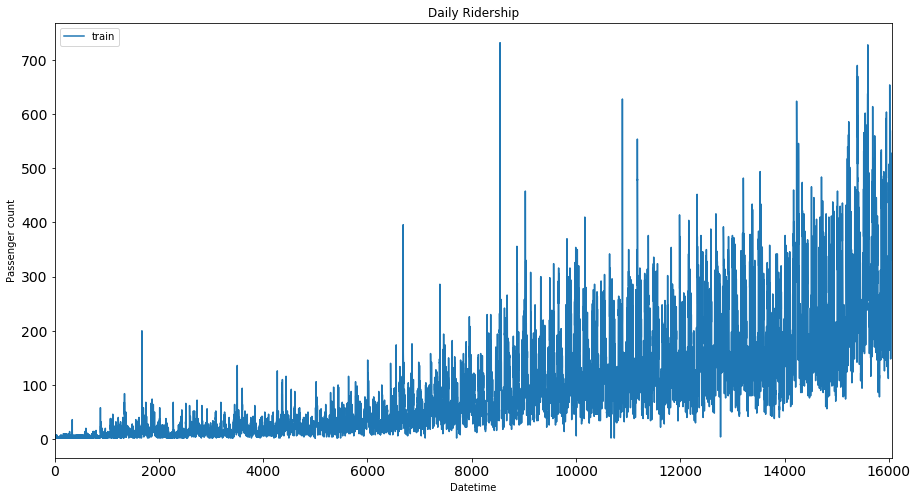

In [7]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

Lets see the visualization of validation dataset

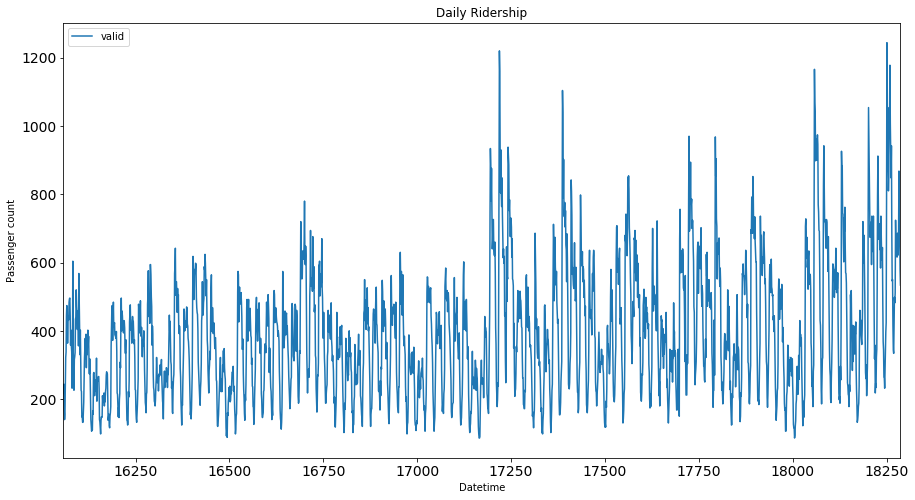

In [16]:
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

## Forecasting Models:

### 1. Naive method

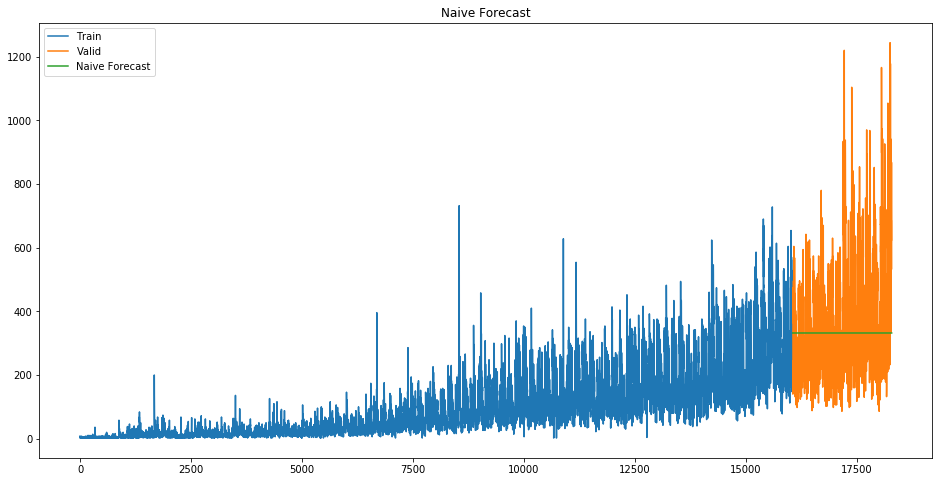

In [17]:
dd = np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1] 
plt.figure(figsize=(16,8)) 
plt.plot(Train.index, Train['Count'], label='Train') 
plt.plot(valid.index,valid['Count'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

In [18]:
#rmse as performance metrices
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive)) 
print(rms)

195.06210118417584


### 2. Moving Average Model
Try the rolling mean of last 50 days and visualize the results

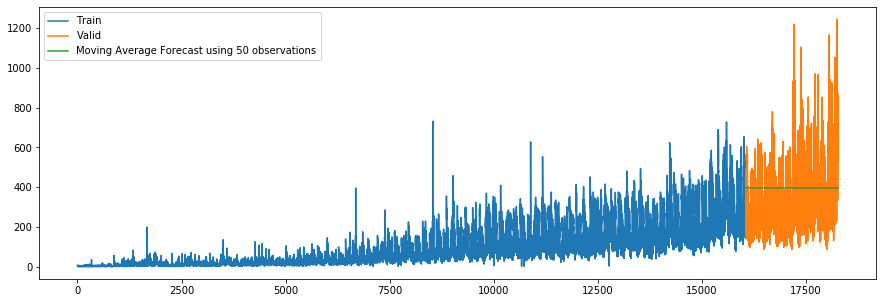

In [19]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast']= Train['Count'].rolling(50).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()

In [20]:
#rmse as performance metrices
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

186.5778781940403


### 3.  simple exponential smoothing
Assign larger weights to more recent observations than to observations from the distant past.

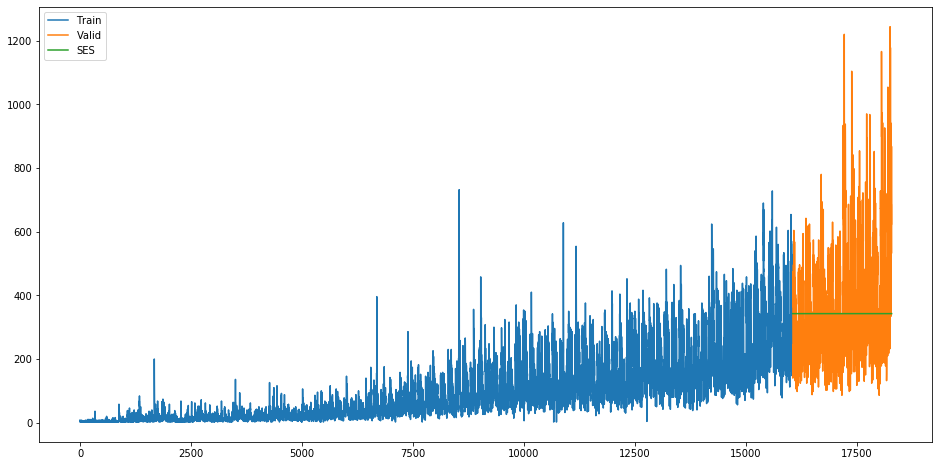

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.8,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 

plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

In [22]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)) 
print(rms)

192.21990001982536


### 4.holt's Linear trend model:
Allow forecasting of data with a trend. visualization of the trend , seasonality and residual of timeseries data

### 5. ARIMA Model
Dickey-Fuller test applied to check if the timeseries is stationary or not



In [9]:
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


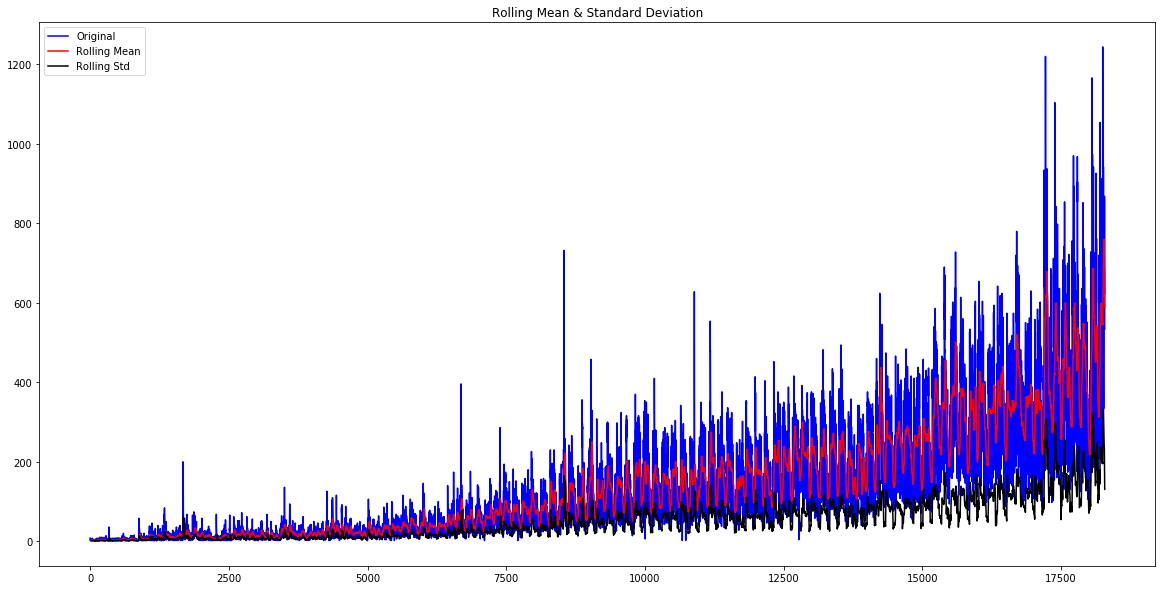

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [10]:
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['Count'])

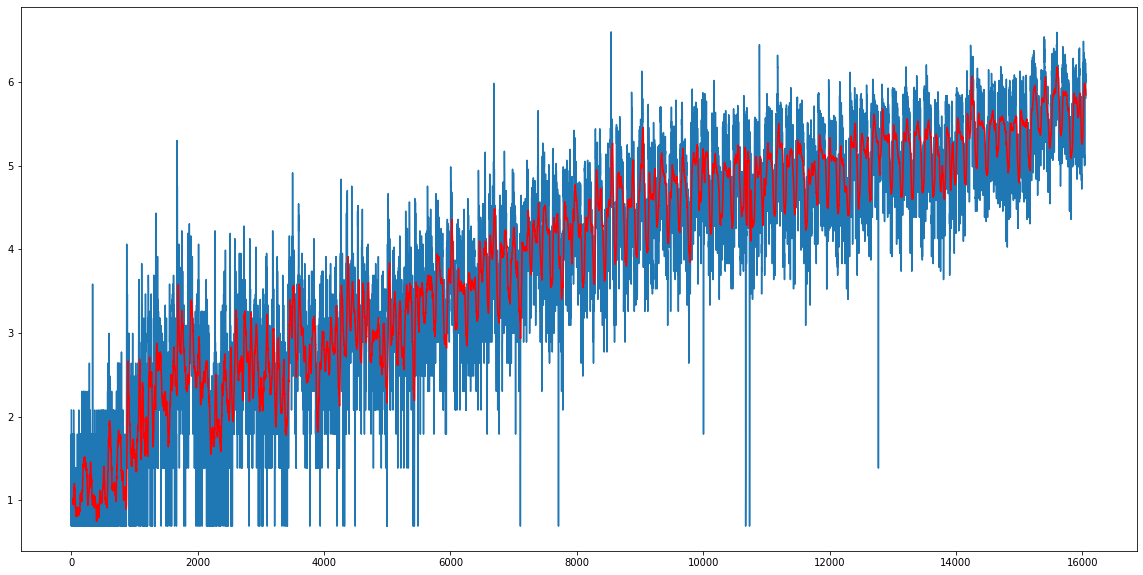

In [11]:
#to make data stationary, we need to remove trend from the datset
Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(24).mean() 
plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

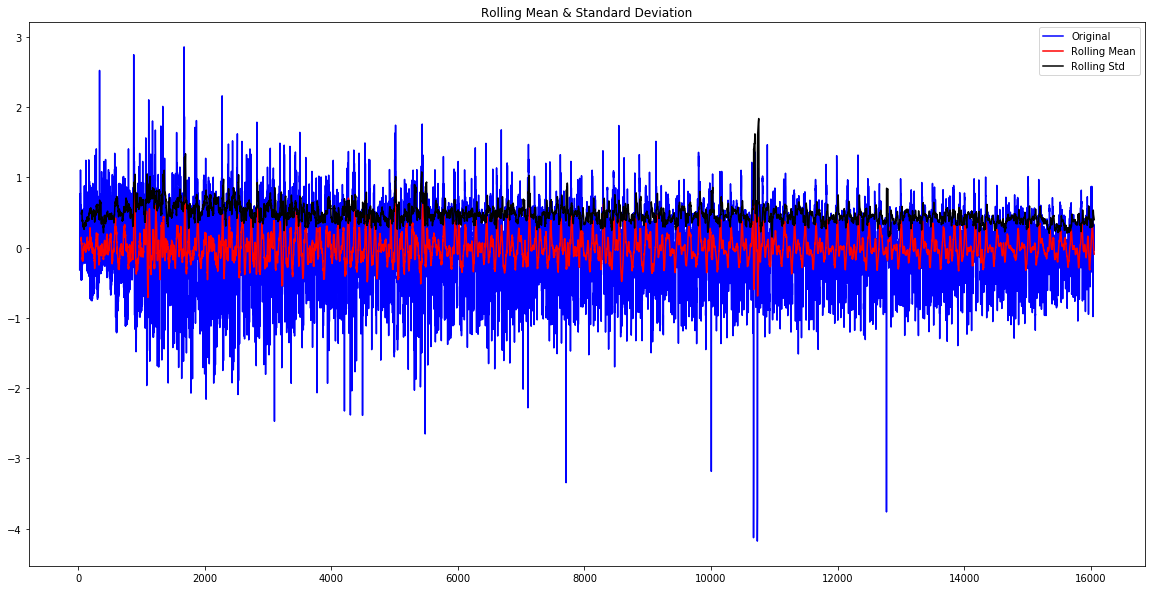

Results of Dickey-Fuller Test:
Test Statistic                   -22.471885
p-value                            0.000000
#Lags Used                        43.000000
Number of Observations Used    15990.000000
Critical Value (1%)               -3.430759
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566866
dtype: float64


In [39]:
train_log_moving_avg_diff = Train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace = True) 
test_stationarity(train_log_moving_avg_diff)

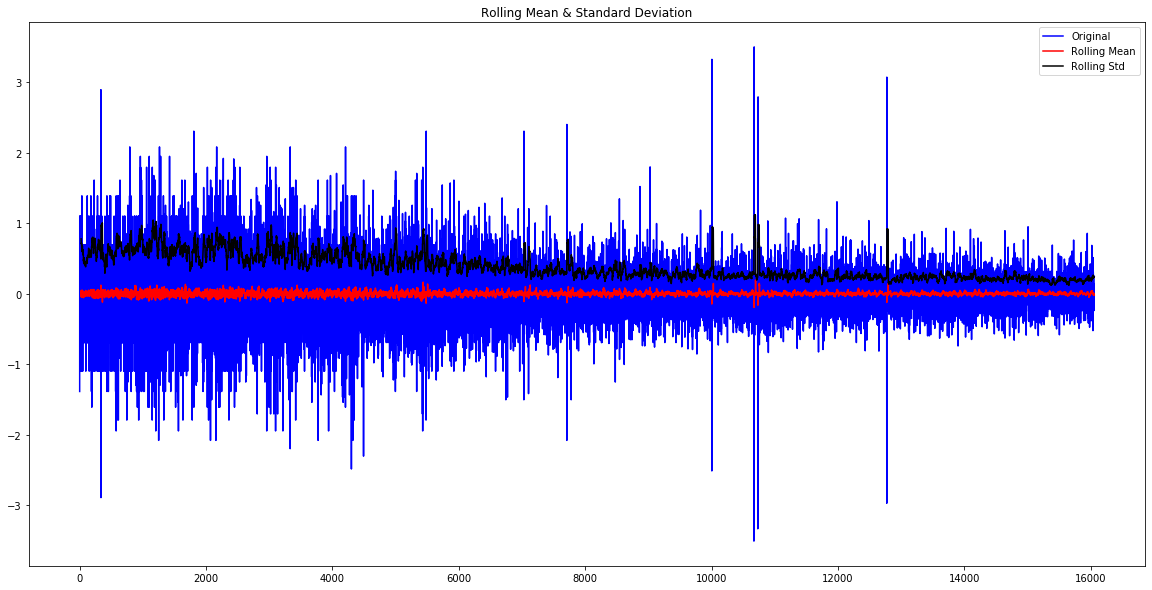

Results of Dickey-Fuller Test:
Test Statistic                   -28.580228
p-value                            0.000000
#Lags Used                        43.000000
Number of Observations Used    16012.000000
Critical Value (1%)               -3.430758
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566866
dtype: float64


In [40]:
train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

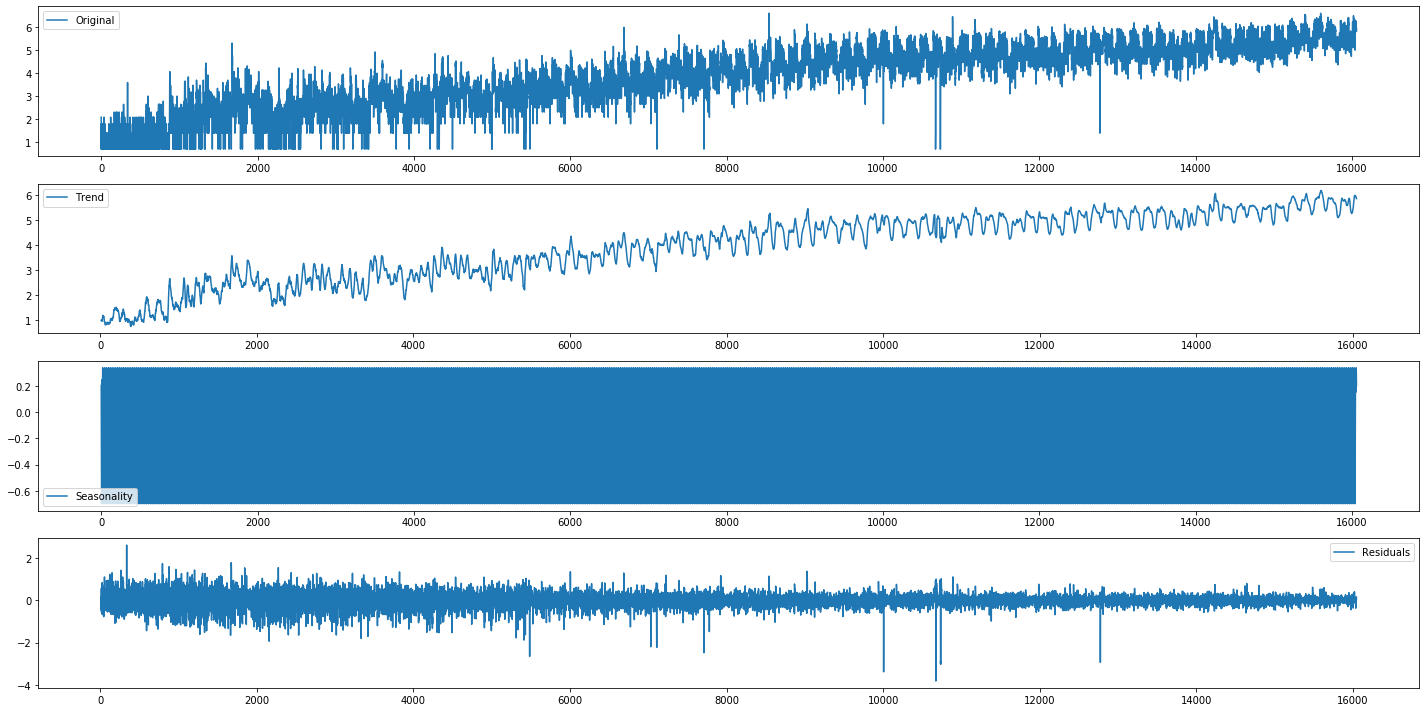

In [41]:
#removing seasonality
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

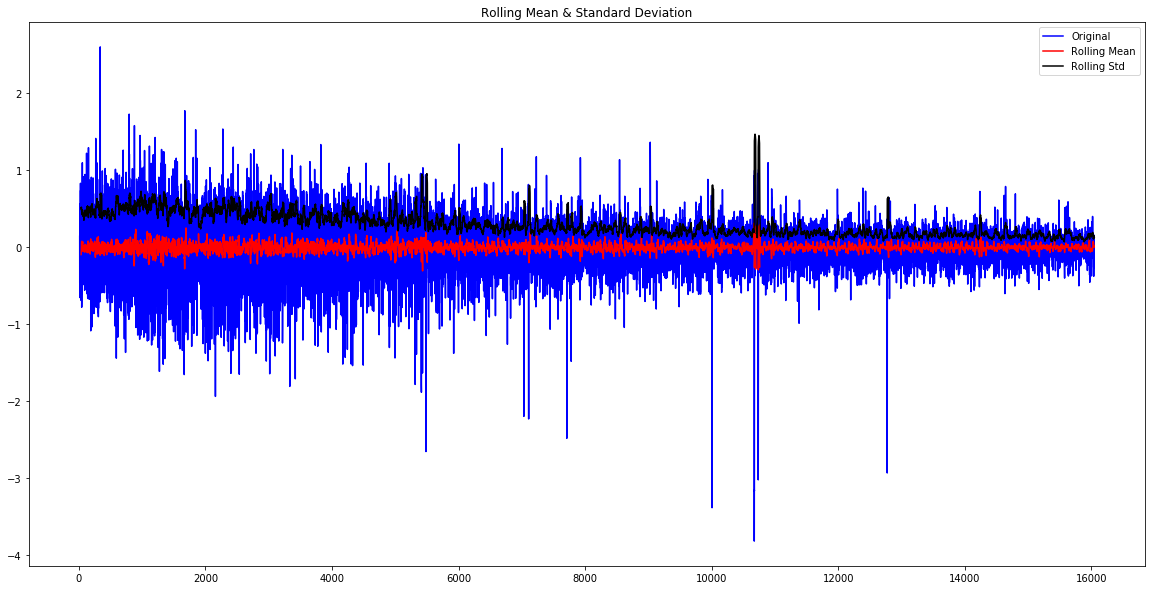

Results of Dickey-Fuller Test:
Test Statistic                   -31.327944
p-value                            0.000000
#Lags Used                        43.000000
Number of Observations Used    15989.000000
Critical Value (1%)               -3.430759
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566866
dtype: float64


In [43]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

In [45]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

/Users/in-vibha.verma/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


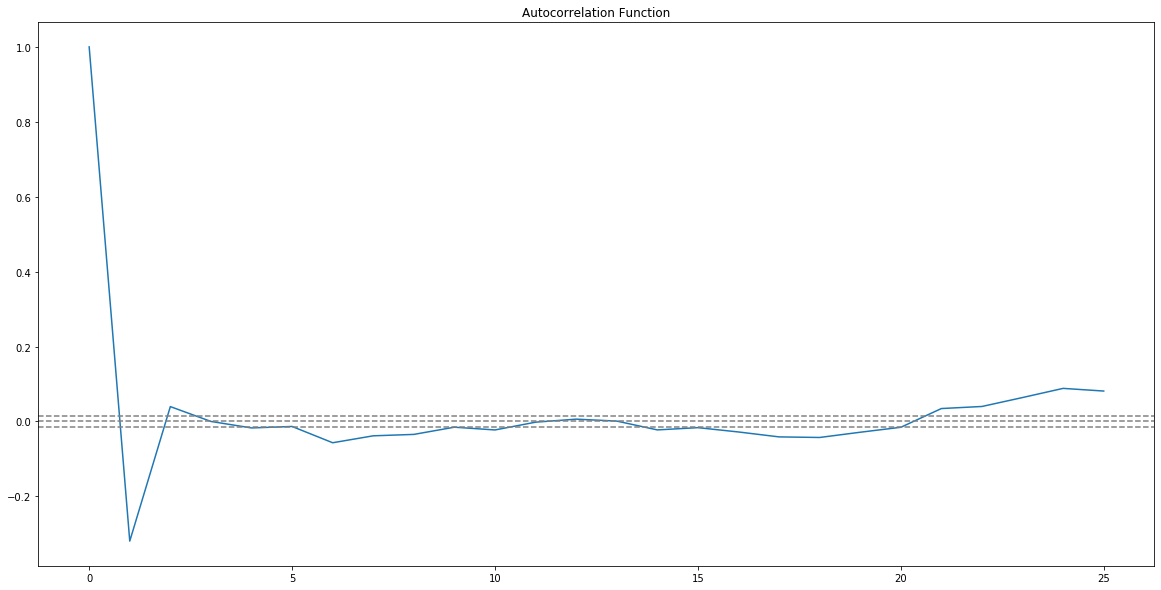

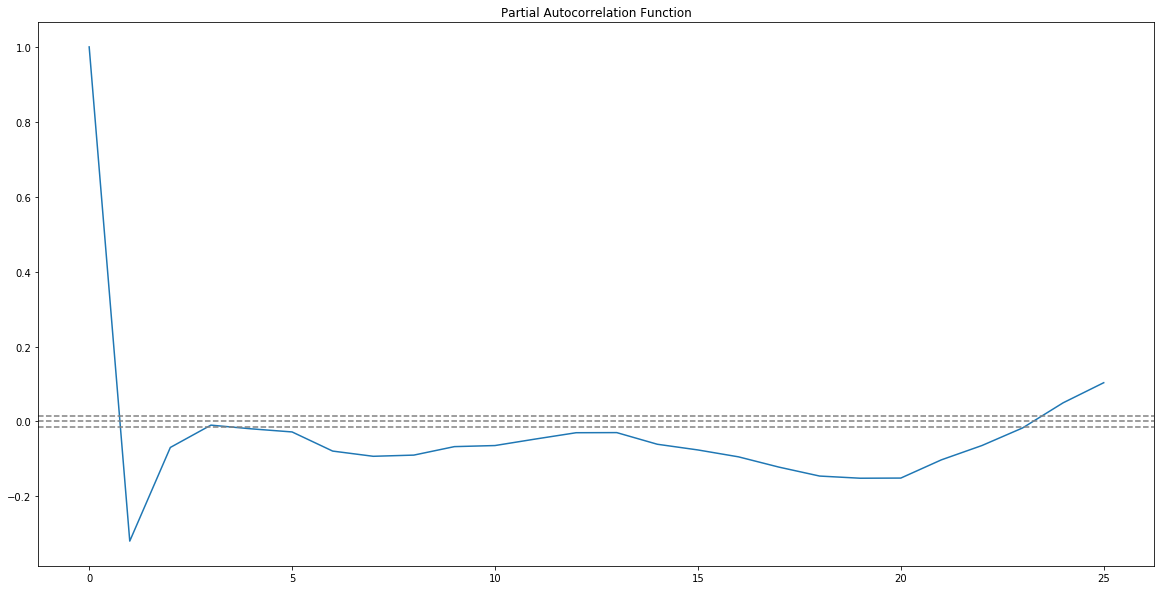

In [48]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 

plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

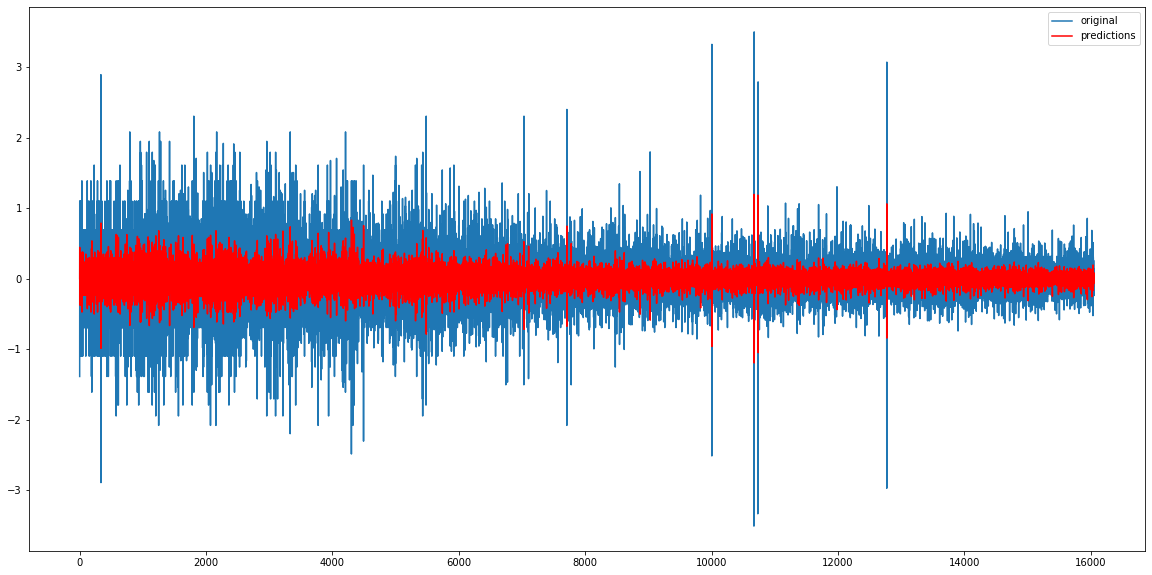

In [49]:
#p=1,q=1
#AR Model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()